In [1]:
! rm -rf output/

In [2]:
# GOOGLE COLLAB

! rm -rf __MACOSX/ landscapes data
! mkdir data
! curl https://cv-project-parceros.s3.amazonaws.com/piezas_repo.zip --output images.zip
! unzip images.zip
! rm -rf __MACOSX/
! mv piezas_repo data/piezas_repo


Streaming output truncated to the last 5000 lines.
  inflating: piezas_repo/peon_rojo/peon_rojo_77_1_3_45.png  
  inflating: piezas_repo/peon_rojo/peon_rojo_81_1_3_7.png  
  inflating: piezas_repo/peon_rojo/peon_rojo_80_1_2_17.png  
  inflating: piezas_repo/peon_rojo/peon_rojo_76_1_2_41.png  
  inflating: piezas_repo/peon_rojo/peon_rojo_76_1_3_2.png  
  inflating: piezas_repo/peon_rojo/peon_rojo_73_2_342_49.png  
  inflating: piezas_repo/peon_rojo/peon_rojo_81_1_4_26.png  
  inflating: piezas_repo/peon_rojo/peon_rojo_77_1_0_3.png  
  inflating: piezas_repo/peon_rojo/peon_rojo_81_1_4_32.png  
  inflating: piezas_repo/peon_rojo/peon_rojo_80_1_0_6.png  
  inflating: piezas_repo/peon_rojo/peon_rojo_75_1_1_8.png  
  inflating: piezas_repo/peon_rojo/peon_rojo_74_1_0_32.png  
  inflating: piezas_repo/peon_rojo/peon_rojo_78_1_3_30.png  
  inflating: piezas_repo/peon_rojo/peon_rojo_73_1_3_38.png  
  inflating: piezas_repo/peon_rojo/peon_rojo_73_1_4_31.png  
  inflating: piezas_repo/peon_rojo/pe

In [3]:
! ls data/piezas_repo

alfil_azul    caballo_rojo  peon_azul	reina_rojo  torre_azul
alfil_rojo    fondo_blanco  peon_rojo	rey_azul    torre_rojo
caballo_azul  fondo_negro   reina_azul	rey_rojo


In [4]:
!pip install split-folders
import splitfolders
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("data/piezas_repo", output="output", seed=1337, ratio=(.7, .1, .2), group_prefix=None) # default values

Copying files: 29799 files [00:04, 6658.12 files/s]


In [5]:
! ls ./output

test  train  val


In [6]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from skimage import io, color

# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray

import matplotlib.pyplot as plt
%matplotlib inline

transform = transforms.Compose([
    #transforms.Grayscale(),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

dataset_train = datasets.ImageFolder("./output/train", transform=transform)
dataset_val = datasets.ImageFolder("./output/val", transform=transform)
dataset_test = datasets.ImageFolder("./output/test", transform=transform)

data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, num_workers=0, shuffle=True)
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=32, num_workers=0, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, num_workers=0, shuffle=True)

dataiter_train = iter(data_loader_train)
dataiter_val = iter(data_loader_val)
dataiter_test = iter(data_loader_val)

In [7]:
print(len(data_loader_test))
print(len(data_loader_val))

187
93


In [8]:
images, labels = dataiter_val.next()
print(images.shape )

torch.Size([32, 3, 64, 64])


In [9]:
print(labels)

tensor([ 7,  6,  5,  6,  7,  3,  3,  7,  0,  5,  5,  6, 13, 12, 12, 11, 13,  2,
         2,  0,  0, 11, 11,  8,  3,  6, 13, 10,  4, 13,  8,  6])


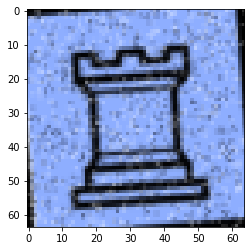

In [10]:
plt.imshow(np.transpose(images[13], (1,2,0)))

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        self.pool2 = nn.MaxPool2d(2,2)
        self.pool4 = nn.MaxPool2d(4,4)
        # First conv layers
        self.conv1 = nn.Conv2d(3, 64, 7, padding=3)
        self.conv2 = nn.Conv2d(64, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256,512, 7, padding=3)
        #self.conv5 = nn.Conv2d(12,6, 3, padding=1)
        #self.conv6 = nn.Conv2d(6,3, 1, padding=0)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 14)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool2(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool4(x)
        x = F.relu(self.conv4(x))
        
        x = self.pool4(x)
        #x = F.relu(self.conv5(x))
        #x = F.relu(self.conv6(x))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# initialize the NN
model = ConvAutoencoder()

# Testing purposes 
X = torch.rand((1,3,64,64))
Y = model(X)
print(X.shape, Y.shape)

torch.Size([1, 3, 64, 64]) torch.Size([1, 14])


In [12]:
import torch.optim as optim
print(f'Using {["CPU", "CUDA"][torch.cuda.is_available()]}')
cuda_available = torch.cuda.is_available()

if cuda_available:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Using CUDA


In [29]:
# number of epochs to train the model
n_epochs = 10
valid_loss_min = np.Inf # track change in validation loss

model.train()
from time import time
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    # monitor training loss
    train_loss = 0.0
    model.train()
    
    ###################
    # train the model #
    ###################
    
    for data in data_loader_train:
        #start = time()
        # Get both images, images_gray is the input, images is the expected output
        images, labels = data

        if cuda_available:
            images = images.cuda()
            labels = labels.cuda()

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
       
        # calculate the loss
        
        loss = criterion(outputs, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in data_loader_val:
        # move tensors to GPU if CUDA is available
        if cuda_available:
          images = data.cuda()
          target = target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(data_loader_train.sampler)
    valid_loss = valid_loss/len(data_loader_val.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
      
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
      
      #print(time() - start)
      #break

Epoch: 1 	Training Loss: 0.032717 	Validation Loss: 0.055389
Validation loss decreased (inf --> 0.055389).  Saving model ...
Epoch: 2 	Training Loss: 0.052671 	Validation Loss: 0.055856
Epoch: 3 	Training Loss: 0.023257 	Validation Loss: 0.007432
Validation loss decreased (0.055389 --> 0.007432).  Saving model ...
Epoch: 4 	Training Loss: 0.019483 	Validation Loss: 0.015915
Epoch: 5 	Training Loss: 0.005918 	Validation Loss: 0.002027
Validation loss decreased (0.007432 --> 0.002027).  Saving model ...
Epoch: 6 	Training Loss: 0.002600 	Validation Loss: 0.019332
Epoch: 7 	Training Loss: 0.024583 	Validation Loss: 0.003868
Epoch: 8 	Training Loss: 0.008337 	Validation Loss: 0.002437
Epoch: 9 	Training Loss: 0.000815 	Validation Loss: 0.000882
Validation loss decreased (0.002027 --> 0.000882).  Saving model ...
Epoch: 10 	Training Loss: 0.000580 	Validation Loss: 0.000575
Validation loss decreased (0.000882 --> 0.000575).  Saving model ...


In [20]:
model.load_state_dict(torch.load('model.pt'))

ConvAutoencoder(
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=14, bias=True)
)

In [30]:
model.eval()
incorrect = []
correct, total = 0, 0

for data in data_loader_test:
    images, labels = data
    if cuda_available:
      images = images.cuda()
      labels = labels.cuda()

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i, b in enumerate(c.cpu().numpy()):
      if not b: incorrect.append(images[i])
    correct += sum(c).item()
    total += len(c)
  
print(f'ACC: {correct / total}')

ACC: 1.0


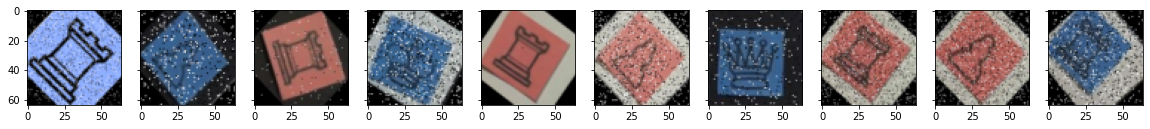

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(20,10))
x = 0
for i in range(10):
    axes[i].imshow(np.transpose(incorrect[i + x].cpu(), (1,2, 0)))

In [22]:
print(correct, total)

5931 5977


In [31]:
torch.save(model.state_dict(), 'model.pt')